In [3]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import tensorflow
from tensorflow.keras.models import Model
from Load_model import CNN_Net
import torchvision.datasets
from torchvision import datasets, transforms

2025-09-25 16:22:04.650862: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


model.0.weight
model.0.bias
model.3.weight
model.3.bias
model.6.weight
model.6.bias
model.10.weight
model.10.bias
model.12.weight
model.12.bias
model.14.weight
model.14.bias
Model Load Sucessful


In [4]:
# Load model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_state_dict = torch.load('mnist_cnn_model.pth', map_location=device)

# Get all parameters
params = list(model_state_dict.items())
n_params = len(params)

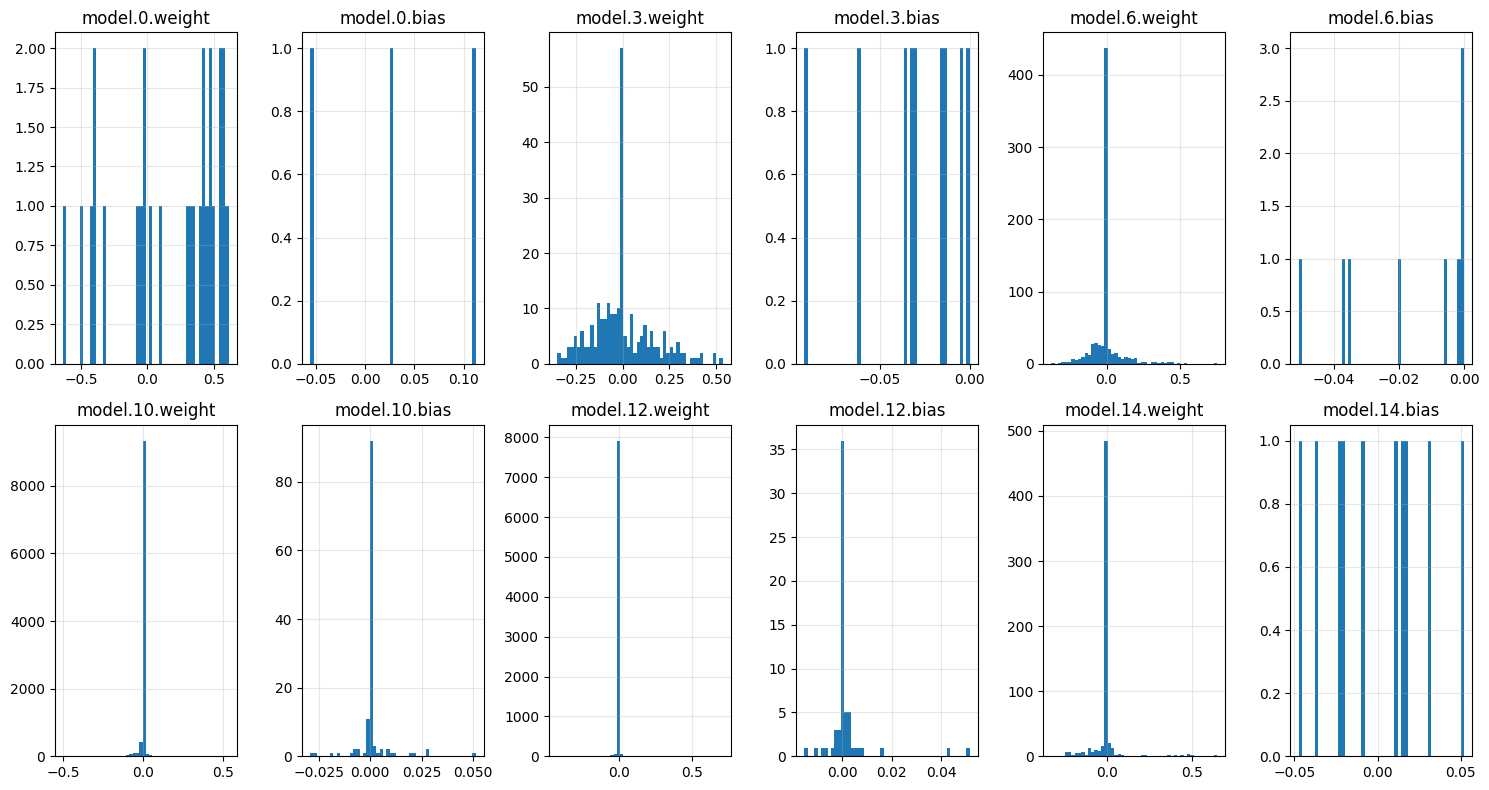

In [5]:
# Create subplots
fig, axes = plt.subplots(2, (n_params + 1) // 2, figsize=(15, 8))
axes = axes.flatten() if n_params > 1 else [axes]

# Plot each parameter
for i, (name, tensor) in enumerate(params):
    values = tensor.cpu().numpy().flatten()
    axes[i].hist(values, bins=50)
    axes[i].set_title(name)
    axes[i].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()


In [6]:
from extractor import Extractor

# Load in model
model = CNN_Net()
model_state_dict = torch.load('mnist_cnn_model.pth', map_location='cpu')

extractor = Extractor(list(model.children()))
extractor.activate()

# Get model byte size
param_size = 0
buffer_size = 0

for param in model.parameters():
    param_size += param.nelement() * param.element_size()

for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('Size: {:.3f} MB'.format(size_all_mb))

Size: 0.078 MB


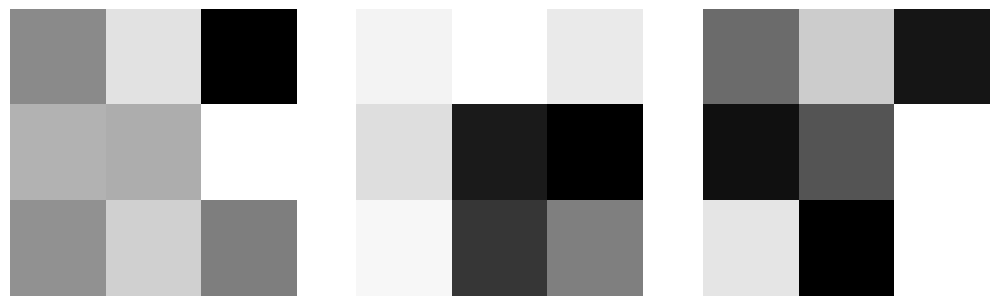

In [7]:
# Visualising the filters
plt.figure(figsize=(35, 35))
for index, filter in enumerate(extractor.CNN_weights[0]):
    plt.subplot(8, 8, index + 1)
    plt.imshow(filter[0, :, :].detach(), cmap='gray')
    plt.axis('off')

plt.show()

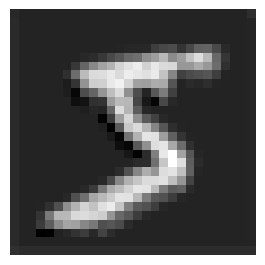

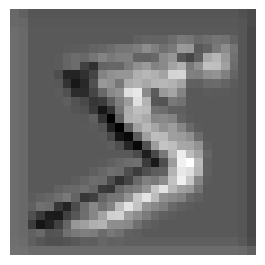

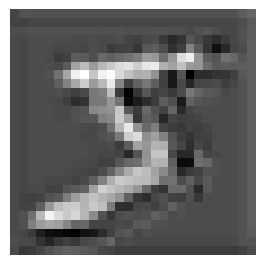

In [8]:
transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))]
)

train_dataset = torchvision.datasets.MNIST(
        root='./data',        
        train=True,           
        download=True,        
        transform=transform  
)

# one test image 
image, label = train_dataset[0]

featuremaps = [extractor.CNN_layers[0](image)]
for x in range(1, len(extractor.CNN_layers)):
    featuremaps.append(extractor.CNN_layers[x](featuremaps[-1]))

# Visualising the featuremaps
for x in range(len(featuremaps)):
    plt.figure(figsize=(30, 30))
    layers = featuremaps[x][0, :, :].detach()
    plt.subplot(8, 8, i + 1)
    plt.imshow(layers, cmap='gray')
    plt.axis('off')

plt.show()

In [9]:
# Post-training quantization with min-max quantization

# Clamping function
def clamp(params_q: np.array, lower_bound: int, upper_bound: int) -> np.array:
    """
    input: params_q = unquantizied parameter, lower_bound = -(2^(n-1) - 1), upper_bound = 2^(n-1)
    output: clamped parameter
    """
    params_q[params_q < lower_bound] = lower_bound
    params_q[params_q > upper_bound] = upper_bound
    return params_q

# symmetric int quantization
def symmetric_quantization(params: np.array, bits: int) -> tuple[np.array, float]:
    """
    input: params = tensor, bits = bit size
    output: quantized = int8, scale = scaling factor for quantization
    """
    # Calculate the scale
    alpha = np.max(np.abs(params))
    scale = alpha / (2**(bits-1)-1)
    lower_bound = -2**(bits-1)
    upper_bound = 2**(bits-1)-1
    # Quantize the parameters
    quantized = clamp(np.round(params / scale), lower_bound, upper_bound).astype(np.int32)
    return quantized, scale

tensor model.0.weight scaling factor 0.004997492767870426: tensor([[[[ -79,  -99,  -85],
          [  -6,  -17,  -11],
          [ 113,   99,   80]]],


        [[[ -65,   22,   89],
          [  -4,   86,   94],
          [  94,  108,   63]]],


        [[[ 115,    5, -127],
          [ 109,   61,  -81],
          [  69,  122,   87]]]], dtype=torch.int32)
tensor model.0.bias scaling factor 0.0008834014879539609: tensor([-63, 127,  30], dtype=torch.int32)
tensor model.3.weight scaling factor 0.00421116454526782: tensor([[[[ 62,   1, -34],
          [ 72,  56,   7],
          [-22,  -5,  26]],

         [[-60, -81, -62],
          [ 21, -12, -63],
          [ 11,  12, -12]],

         [[-31, -61, -47],
          [ 48,  36,   9],
          [ -6,  42,  88]]],


        [[[-39, -18, -31],
          [-26, -51, -59],
          [-20, -53, -28]],

         [[-58,  23,  71],
          [-41,  43,  20],
          [-15,  34,  -7]],

         [[-52, -18,  -4],
          [-50,  -7,  60],
          [

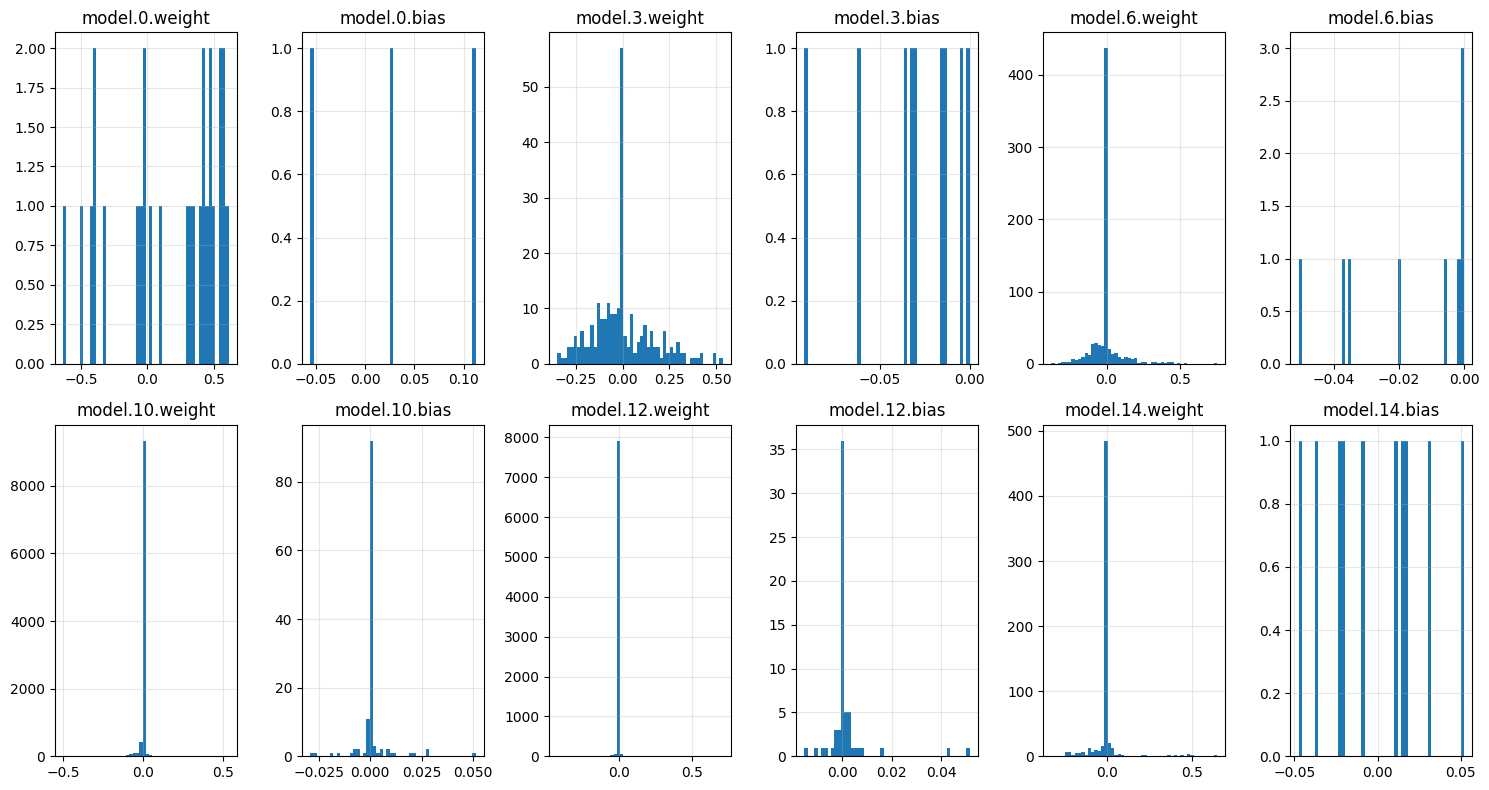

In [14]:
fig, axes = plt.subplots(2, (n_params + 1) // 2, figsize=(15, 8))
axes = axes.flatten() if n_params > 1 else [axes]
quant_tensors = {}
scaling_factors = []

# quantized tensors
for i, (name, tensor) in enumerate(params):
  original_shape = tensor.shape
  values = tensor.cpu().numpy().flatten()
  quantized_values = symmetric_quantization(values, 8)
  quantized_array = quantized_values[0]
  quantized_tensor = torch.from_numpy(quantized_array).reshape(original_shape)

  print(f"tensor {name} scaling factor {quantized_values[1]}: {quantized_tensor}")
  scaling_factors.append(quantized_values[1])
  quant_tensors[name] = quantized_tensor

  axes[i].hist(values, bins=50)
  axes[i].set_title(name)
  axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
  

In [ ]:
# Upload quantized tensors to model through dequantization
dequantized_dict = {}
errors = []

def dequant(scale: float, quant_tensor, original_tensor):
  """
  input: scale = scaling facotr for quantization, quant_tensor = quantized tensored in int8, original_tensor = fp32 original tensors
  output: fp32_tensor = scaled up tensor from int 8 to fp32, max_error = quantization error
  """
  fp32_tensor = quant_tensor * scale
  quant_error = fp32_tensor - original_tensor
  max_error = torch.max(abs(quant_error))
  return fp32_tensor, max_error

for i, (name, tensor) in enumerate(params):
  original_shape = tensor.shape
  values = tensor.cpu().numpy().flatten()

  dequantized_values = dequant(scaling_factors[i], quant_tensors[name], tensor)
  dequantized_tensor, error = dequantized_values
  errors.append(error.cpu().numpy().flatten())

  dequantized_dict[name] = dequantized_tensor

[array([0.00249356], dtype=float32), array([0.00034595], dtype=float32), array([0.00210311], dtype=float32), array([0.00025653], dtype=float32), array([0.00296003], dtype=float32), array([0.00019612], dtype=float32), array([0.00211033], dtype=float32), array([0.00020154], dtype=float32), array([0.00278301], dtype=float32), array([0.00019879], dtype=float32), array([0.00252634], dtype=float32), array([0.00019699], dtype=float32)]


In [ ]:
from Quantization_CNN_Model import QuantizedCNN_Net

QuantizedCNN_Net.load_quantized_tensors(dequantized_dict)


ImportError: cannot import name 'QuantizedCNN_Net' from 'Quantization_CNN_Model' (/workspaces/MNIST_Digit_Recognition/lib/CNN_Model/Quantization_CNN_Model.py)